In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
    import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:

train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

# Save PassengerId from test set for final submission
test_ids = test_df['PassengerId']

# Display the first few rows of each DataFrame
print("Training Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())

Training Data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   Na

In [3]:
 #Extract deck letter from Cabin
import pandas as pd

# Pull the first character of the Cabin string, fill NaNs with 'U' (Unknown)
train_df['Deck'] = train_df['Cabin'].str[0].fillna('U')
test_df['Deck']  = test_df['Cabin'].str[0].fillna('U')

# Encode deck letters to numbers
from sklearn.preprocessing import LabelEncoder
deck_le = LabelEncoder()

# Fit on combined decks so both train & test share the same mapping
deck_le.fit(pd.concat([train_df['Deck'], test_df['Deck']]))

train_df['Deck'] = deck_le.transform(train_df['Deck'])
test_df['Deck']  = deck_le.transform(test_df['Deck'])

# Quick check
print(train_df[['Cabin', 'Deck']].head())

  Cabin  Deck
0   NaN     8
1   C85     2
2   NaN     8
3  C123     2
4   NaN     8


In [4]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

# Fill missing 'Age' with the median value in both datasets
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())

# Fill missing 'Embarked' in train with the most frequent value (mode)
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

# Fill missing 'Fare' in test with the median value
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

# Drop the 'Cabin' column from both datasets (use errors='ignore' in case it's already missing)
train_df.drop(columns=['Cabin'], inplace=True, errors='ignore')
test_df.drop(columns=['Cabin'], inplace=True, errors='ignore')

print("\nMissing values after handling:")
print(train_df.isnull().sum())
print(test_df.isnull().sum())

Missing values in training data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Deck             0
dtype: int64

Missing values in test data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Deck             0
dtype: int64

Missing values after handling:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Deck           0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Deck           0


In [5]:
# Step 3: Extract Titles from Names

def extract_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Apply the function to extract titles
train_df['Title'] = train_df['Name'].apply(extract_title)
test_df['Title'] = test_df['Name'].apply(extract_title)

# Replace uncommon titles with 'Rare' and standardize others
for df in [train_df, test_df]:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 
                                       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Map titles to numeric values
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train_df['Title'] = train_df['Title'].map(title_mapping)
test_df['Title'] = test_df['Title'].map(title_mapping)

# If any titles are missing after mapping, fill them with 0
train_df['Title'] = train_df['Title'].fillna(0)
test_df['Title'] = test_df['Title'].fillna(0)

print("\nTitles extracted and mapped (first 5 rows):")
print(train_df[['Name', 'Title']].head())







Titles extracted and mapped (first 5 rows):
                                                Name  Title
0                            Braund, Mr. Owen Harris      1
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      3
2                             Heikkinen, Miss. Laina      2
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      3
4                           Allen, Mr. William Henry      1


In [6]:
# Step 4: Create FamilySize and IsAlone Features

# Create FamilySize feature: sum of SibSp and Parch
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch']
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']

# Create IsAlone feature: 1 if FamilySize is 0, else 0
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 0, 'IsAlone'] = 1

test_df['IsAlone'] = 0
test_df.loc[test_df['FamilySize'] == 0, 'IsAlone'] = 1

print("\nFamilySize and IsAlone (first 5 rows):")
print(train_df[['SibSp', 'Parch', 'FamilySize', 'IsAlone']].head())




FamilySize and IsAlone (first 5 rows):
   SibSp  Parch  FamilySize  IsAlone
0      1      0           1        0
1      1      0           1        0
2      0      0           0        1
3      1      0           1        0
4      0      0           0        1


In [7]:
# Step 5: Convert Categorical Variables

# Convert 'Sex' to numeric: male = 1, female = 0
for df in [train_df, test_df]:
    df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
    
# Convert 'Embarked' to numeric: C = 0, Q = 1, S = 2
for df in [train_df, test_df]:
    df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

print("\nConverted categorical variables (first 5 rows):")
print(train_df[['Sex', 'Embarked']].head())



Converted categorical variables (first 5 rows):
   Sex  Embarked
0    1         2
1    0         0
2    0         2
3    0         2
4    1         2


In [8]:
# Advanced Feature Engineering - Binning Age and Fare

for df in [train_df, test_df]:
    # Create 'AgeBin' by binning Age into 4 categories:
    # 0: Child (0-12), 1: Teen (12-20), 2: Adult (20-40), 3: Senior (40-120)
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 120], labels=[0, 1, 2, 3])
    
    # Create 'FareBin' by splitting Fare into 4 quartile-based categories
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=False)

# Display the new features for a quick check
print("Advanced Features Added (AgeBin and FareBin):")
print(train_df[['Age', 'AgeBin', 'Fare', 'FareBin']].head())


Advanced Features Added (AgeBin and FareBin):
    Age AgeBin     Fare  FareBin
0  22.0      2   7.2500        0
1  38.0      2  71.2833        3
2  26.0      2   7.9250        1
3  35.0      2  53.1000        3
4  35.0      2   8.0500        1


In [9]:
# Additional Feature Engineering

# --- Ticket Prefix Extraction ---
def extract_ticket_prefix(ticket):
    # Split the ticket string by spaces and take the first part if there is a prefix
    ticket_parts = ticket.split()
    if len(ticket_parts) > 1:
        # Remove dots or slashes from the prefix
        return ticket_parts[0].replace('.', '').replace('/', '')
    else:
        return "XXX"  # Placeholder for tickets with no prefix

# Apply the extraction to both datasets
for df in [train_df, test_df]:
    df['TicketPrefix'] = df['Ticket'].apply(extract_ticket_prefix)
    
# Encode the TicketPrefix feature using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le_ticket = LabelEncoder()
for df in [train_df, test_df]:
    df['TicketPrefix'] = le_ticket.fit_transform(df['TicketPrefix'])

# --- Family Category ---
# Create a categorical feature based on FamilySize:
# 0 = Alone, 1 = Small Family (1-4 members), 2 = Large Family (more than 4 members)
for df in [train_df, test_df]:
    df['FamilyCategory'] = pd.cut(df['FamilySize'], bins=[-1, 0, 4, 100], labels=[0, 1, 2])

# --- Log Transformation for Fare ---
# Apply a log transformation to Fare to reduce skewness
for df in [train_df, test_df]:
    df['Fare_log'] = np.log1p(df['Fare'])

# (Optional) Display the new features for a quick check
print("New features added (first 5 rows):")
print(train_df[['Ticket', 'TicketPrefix', 'FamilySize', 'FamilyCategory', 'Fare', 'Fare_log']].head())


New features added (first 5 rows):
             Ticket  TicketPrefix  FamilySize FamilyCategory     Fare  \
0         A/5 21171             1           1              1   7.2500   
1          PC 17599             9           1              1  71.2833   
2  STON/O2. 3101282            25           0              0   7.9250   
3            113803            29           1              1  53.1000   
4            373450            29           0              0   8.0500   

   Fare_log  
0  2.110213  
1  4.280593  
2  2.188856  
3  3.990834  
4  2.202765  


In [10]:
#Additional Feature Engineering – FarePerPerson and Age*Pclass

for df in [train_df, test_df]:
    # Fare per person: fare divided by (family size + 1)
    df['FarePerPerson'] = df['Fare'] / (df['FamilySize'] + 1)
    # Interaction feature: Age multiplied by Pclass
    df['Age*Pclass'] = df['Age'] * df['Pclass']

# Quick check of the new features
print(train_df[['Fare', 'FamilySize', 'FarePerPerson', 'Age', 'Pclass', 'Age*Pclass']].head())

      Fare  FamilySize  FarePerPerson   Age  Pclass  Age*Pclass
0   7.2500           1        3.62500  22.0       3        66.0
1  71.2833           1       35.64165  38.0       1        38.0
2   7.9250           0        7.92500  26.0       3        78.0
3  53.1000           1       26.55000  35.0       1        35.0
4   8.0500           0        8.05000  35.0       3       105.0


In [11]:
#Convert categorical dtypes to numeric codes
for col in ['AgeBin', 'FamilyCategory']:
    train_df[col] = train_df[col].astype(int)
    test_df[col]  = test_df[col].astype(int)

In [12]:
# Step 6: Drop Unnecessary Columns

# For training data, drop 'PassengerId', 'Name', 'Ticket'
train_df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True, errors='ignore')

# For test data, drop 'Name', 'Ticket'
# (Keep PassengerId separately in test_ids for final submission)
test_df.drop(columns=['Name', 'Ticket'], inplace=True, errors='ignore')

print("\nTraining data columns after dropping unnecessary ones:")
print(train_df.columns)
print("\nTest data columns after dropping unnecessary ones:")
print(test_df.columns)



Training data columns after dropping unnecessary ones:
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Deck', 'Title', 'FamilySize', 'IsAlone', 'AgeBin',
       'FareBin', 'TicketPrefix', 'FamilyCategory', 'Fare_log',
       'FarePerPerson', 'Age*Pclass'],
      dtype='object')

Test data columns after dropping unnecessary ones:
Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Deck', 'Title', 'FamilySize', 'IsAlone', 'AgeBin',
       'FareBin', 'TicketPrefix', 'FamilyCategory', 'Fare_log',
       'FarePerPerson', 'Age*Pclass'],
      dtype='object')


In [13]:
# Step 7: Prepare Data for Modeling

# For training, separate features (X) and target (y)
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# For testing, X_test is the entire test_df (PassengerId is saved separately)
X_test = test_df.copy()

print("Shape of training features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("Shape of test features (X_test):", X_test.shape)


Shape of training features (X): (891, 18)
Shape of target (y): (891,)
Shape of test features (X_test): (418, 19)


In [14]:
# Step 8: Split the Data into Training and Validation Sets
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)



X_train shape: (712, 18)
X_val shape: (179, 18)


In [15]:
# Step 9: Train CatBoostClassifier
from catboost import CatBoostClassifier

# List your categorical columns
cat_cols = ['Sex', 'Embarked', 'Title', 'TicketPrefix', 'FamilyCategory', 'Deck']

cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    early_stopping_rounds=30,
    verbose=100
)

# Train, telling CatBoost which columns are categorical
cb.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=(X_val, y_val)
)




0:	learn: 0.6579211	test: 0.6593344	best: 0.6593344 (0)	total: 62.6ms	remaining: 31.2s
100:	learn: 0.3088554	test: 0.3956429	best: 0.3936849 (93)	total: 431ms	remaining: 1.7s
200:	learn: 0.2553200	test: 0.3856283	best: 0.3848518 (196)	total: 793ms	remaining: 1.18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3824680663
bestIteration = 227

Shrink model to first 228 iterations.


In [16]:
# Step 10: Evaluate CatBoost
val_preds = cb.predict(X_val)
from sklearn.metrics import accuracy_score, confusion_matrix

print("CatBoost Validation Accuracy:", accuracy_score(y_val, val_preds))
print("CatBoost Confusion Matrix:\n", confusion_matrix(y_val, val_preds))







CatBoost Validation Accuracy: 0.8491620111731844
CatBoost Confusion Matrix:
 [[93 12]
 [15 59]]


In [17]:
# Step 11: Predict & Submit with CatBoost
X_test = test_df.drop(columns=['PassengerId'], errors='ignore')
test_preds = cb.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Survived': test_preds
})
submission.to_csv('submission_catboost.csv', index=False)
print("Created submission_catboost.csv")







Created submission_catboost.csv


Feature Importances:
Title             20.969492
Deck               9.503933
Sex                8.296094
Age*Pclass         7.330044
Embarked           6.609846
Pclass             6.586392
FamilyCategory     6.522944
FarePerPerson      5.903809
TicketPrefix       5.847138
Age                5.124655
Fare               4.358010
FamilySize         3.852179
Fare_log           2.891930
FareBin            1.853972
AgeBin             1.646833
SibSp              1.340923
Parch              1.147585
IsAlone            0.214223
dtype: float64


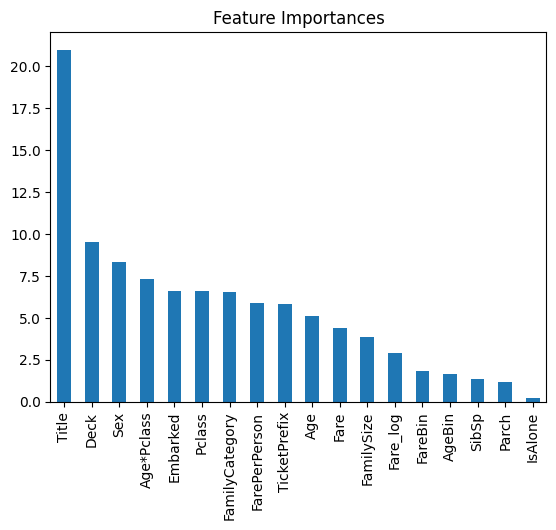

In [18]:
# Step 12: Visualize Feature Importances

import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the CatBoost model
importances = cb.get_feature_importance()
feature_names = X.columns

# Create a pandas series for feature importances
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Print feature importances
print("Feature Importances:")
print(feat_importances)

# Plot the feature importances
feat_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()
